In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection

In [4]:
data=pd.read_csv("/content/drive/My Drive/GEARS2022/code/helpful_data_multisemester_balanced.csv")
# Split the data to train data and test data
X_train_tmp, X_test, y_train_tmp, y_test = model_selection.train_test_split(data['REVIEW'],data['TAG'], random_state = 0)
X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train_tmp,y_train_tmp, random_state = 0)

In [5]:
# Create sequences of tokens uniform in length for all reviews
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=100)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=100)

X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=100)

In [6]:
embedding_size = 128
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(20000, embedding_size, input_shape=(100,)))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 100, 25)           15400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           5100      
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                        

In [7]:
history = model.fit(X_train_tok_pad, y_train, epochs=50, batch_size=1024,validation_data=(X_val_tok_pad, y_val))

Epoch 1/50
3/3 [==============================] - 13s 2s/step - loss: 2.7561 - accuracy: 0.4978 - val_loss: 1.3725 - val_accuracy: 0.5221
Epoch 2/50
3/3 [==============================] - 0s 90ms/step - loss: 1.4794 - accuracy: 0.4978 - val_loss: 1.0789 - val_accuracy: 0.5221
Epoch 3/50
3/3 [==============================] - 0s 96ms/step - loss: 1.1536 - accuracy: 0.4982 - val_loss: 0.8896 - val_accuracy: 0.5221
Epoch 4/50
3/3 [==============================] - 0s 96ms/step - loss: 0.9608 - accuracy: 0.4933 - val_loss: 0.7731 - val_accuracy: 0.5221
Epoch 5/50
3/3 [==============================] - 0s 104ms/step - loss: 0.9968 - accuracy: 0.4946 - val_loss: 0.7292 - val_accuracy: 0.5221
Epoch 6/50
3/3 [==============================] - 0s 104ms/step - loss: 1.0337 - accuracy: 0.4915 - val_loss: 0.7270 - val_accuracy: 0.5221
Epoch 7/50
3/3 [==============================] - 0s 127ms/step - loss: 0.9061 - accuracy: 0.4906 - val_loss: 0.7528 - val_accuracy: 0.5221
Epoch 8/50
3/3 [=========

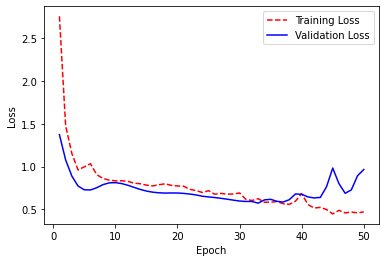

In [8]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
model.evaluate(X_test_tok_pad, y_test, batch_size=1024)

1/1 [==============================] - 0s 48ms/step - loss: 0.9543 - accuracy: 0.6999


[0.954259991645813, 0.6998993158340454]

In [10]:
# Examine classification report
from sklearn.metrics import classification_report
#y_pred_classes = model.predict_classes(X_test_tok_pad, batch_size=2048)
predict_y=model.predict(X_test_tok_pad, batch_size=2048)
classes_y=np.argmax(predict_y,axis=-1)
print(classification_report(y_test, classes_y))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       485
           1       0.00      0.00      0.00       508

    accuracy                           0.49       993
   macro avg       0.24      0.50      0.33       993
weighted avg       0.24      0.49      0.32       993



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
